Frustrated by the maze of parameters in LLM fine-tuning? Confused by Hugging Face’s PEFT library? Let’s cut through the jargon and understand fine-tuning.

We will use provide you a simple and easy readup for using the hugging face library for fine-tuning a language model.

Supervised Fine-Tuning(SFT):
Supervised Fine-tuning is used for task-specific use cases. The model is trained on a labeled dataset. One can implement SFT in the following ways:

* Full parameter fine-tuning: fine-tuning the whole model.
* Parameter-efficient fine-tuning (PEFT): fine-tuning a specific set of parameters.
* Instruction fine-tuning: fine-tuning based on instruction-format dataset.
  
We will focus on SFT with PEFT

#### Parameter-efficient fine-tuning (PEFT) Workflow:
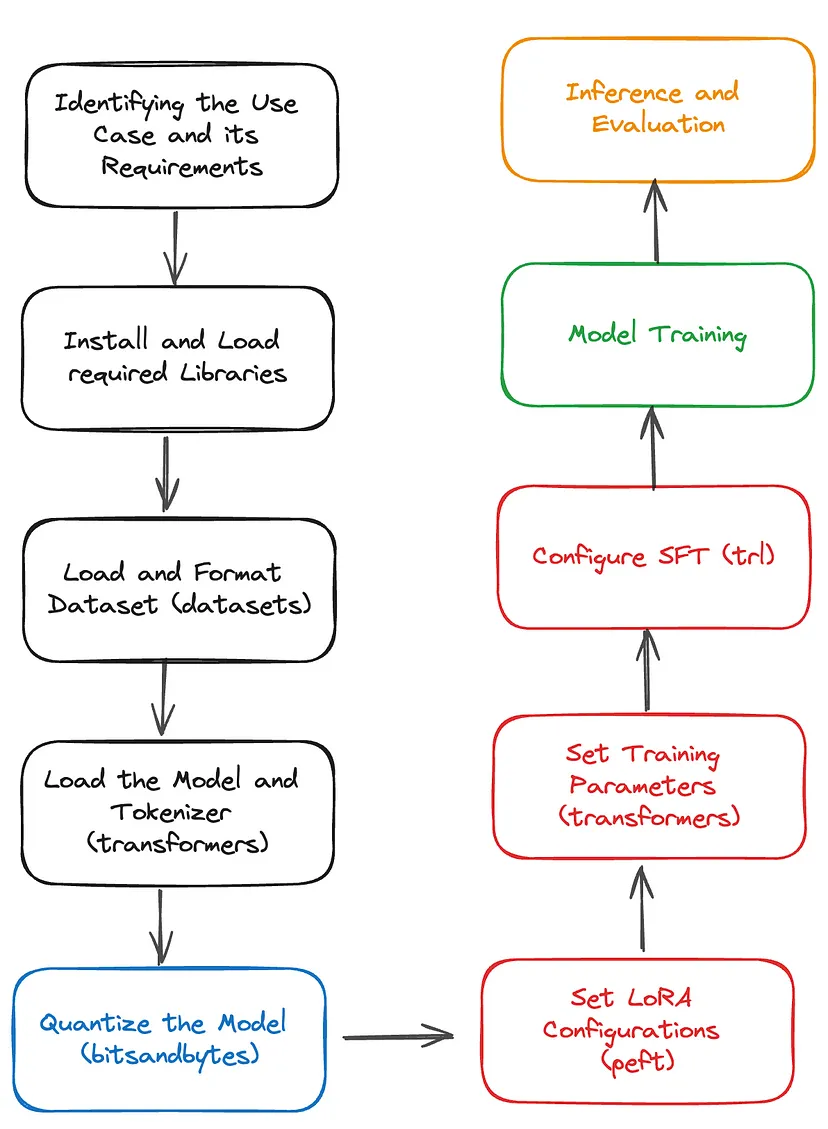

#### Dataset: 
The datasets library accesses various dataset types from Audio, Computer Vision, and NLP tasks. For SFT, the dataset must have a text column.

#### Transformers:
The transformers library loads, trains, and runs the language models. For PEFT, we use the following classes in general:

* AutoModelForCausalLM — to load the model
* AutoTokenizer — to load the tokenizer
* BitsAndBytesConfig — to convert the model into the desired quantization type, 4-bit or 8-bit
* TrainingArguments — to define the training parameters like learning rate, optimizer, batch size, output directory…

#### Bitsandbytes:
The bistandbytes library quantizes the model to 8-bit and 4-bit. It is commonly used with QLoRA to fine-tune quantized LLMs.

With PEFT, you can use bitsandbytes to load the model in the desired quantization, set the compute data type, set the quantization type, and even use nested quantization to reduce the memory footprint further.

Parameters:

* load_in_4bit, load_in_8bit: to load the model in 4-bit or 8-bit respectively.
* bnb_4bit_compute_dtype: sets the computational type, which might differ from the input type. For example, inputs might be
fp32, but computation can be set to bf16 for speedups.
* bnb_4bit_quant_type: sets the quantization data type in the bnb.nn.Linear4Bit layers. Options are FP4 and NF4 data types
which are specified by `fp4` or `nf4`.
* bnb_4bit_use_double_quant: used for nested quantization where the quantization constants from the first quantization are
quantized again. Reduces further memory footprint.

#### Peft:
The peft library provides a PeftConfig class, which stores all the essential parameters for the PeftModel. We can use this library to train a model with LoRA, Prompt-based methods, IA3, etc.

In general, we use the following for LoRA

LoraConfig:
 *r: rank, LoRA attention dimension. 8 is ideal.
* lora_alpha: parameter for LoRA scaling.
* lora_dropout: dropout probability for LoRA layers. Regularization.
* bias: bias type for LoRA. Can be ‘none’, ‘all’ or ‘lora_only’.
* target_modules: names of the modules to which the adapter should apply. You can find the module names by simply printing the model. For example, [“q_proj”, “k_proj”, “v_proj”, “o_proj”, ”gate_proj”, “up_proj”]
SFTTrainer requires a peft_config parameter. We pass LoraConfig along with task_type as peft_config.

Overview of the supported task types:
- SEQ_CLS: Text classification.
- SEQ_2_SEQ_LM: Sequence-to-sequence language modeling.
- Causal LM: Causal language modeling.
- TOKEN_CLS: Token classification.
- QUESTION_ANS: Question answering.
- FEATURE_EXTRACTION: This process extracts features and provides hidden states that can be used as embeddings or features for downstream tasks.

##### Task Types:
- SEQ_CLS = “SEQ_CLS”
- SEQ_2_SEQ_LM = “SEQ_2_SEQ_LM”
- CAUSAL_LM = “CAUSAL_LM”
- TOKEN_CLS = “TOKEN_CLS”
- QUESTION_ANS = “QUESTION_ANS”
- FEATURE_EXTRACTION = “FEATURE_EXTRACTION”

```python
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj"]
)
```

##### TrainingArguments:
your model can accept multiple label argument via TrainingArguments to indicate their name to the Trainer
```python
training_arguments = TrainingArguments(
    output_dir="./results", # directory to store the model predictions and checkpoints
    num_train_epochs=5, # number of epochs
    per_device_train_batch_size=4, # batch size for training per GPU or core CPU
    per_device_eval_batch_size=4, # batch size for evaluating per GPU or core CPU
    gradient_accumulation_steps=1, # number of updates steps to accumulate the gradients for, before performing a backward/update pass
    optim="paged_adamw_32bit", # the optimizer to use
    save_steps=50, # number of updates steps before two checkpoint saves
    logging_steps=50, # number of update steps between two logs
    learning_rate=2e-4, # 0.0002 initial learning rate for [`AdamW`] optimizer
    lr_scheduler_type="constant", # the scheduler type to use
    warmup_ratio=0.03, # ratio of total training steps used for a linear warmup from 0 to `learning_rate`
    weight_decay=0.001, # the weight decay to apply to all layers except all bias and LayerNorm weights in [`AdamW`] optimizer
    fp16=False, # whether to use fp16 16-bit (mixed) precision training instead of 32-bit training
    bf16=False, # whether to use bfp16 16-bit (mixed) precision training instead of 32-bit training
    max_grad_norm=0.3, # maximum gradient norm (for gradient clipping)
    max_steps=-1, # if set to a positive number, the total number of training steps to perform. Overrides `num_train_epochs`    group_by_length=True, # Whether or not to group together samples of roughly the same length in the training dataset
    report_to="tensorboard", # the list of integrations to report the results and logs to - [wandb, mlflow, comet_ml, neptune...]
)
```

The trl(Transformer Reinforcement Library) library provides tools for training transformer language models with SFT and RLHF.

For SFT, we use the following classes:

SFTConfig
SFTTrainer

We use SFTTrainer to finetune the model based on all the training arguements and qunantized model
```python
trainer = SFTTrainer(
    model=model_name, # model to train
    train_dataset=dataset, # the training dataset
    eval_dataset=eval_dataset, # the evaluation dataset
    peft_config=peft_config, # from LoRA Configuration
    dataset_text_field="text", # pointing to the 'text' column in the dataset
    max_seq_length=40, # it determines the maximum length of input sequences during fine-tuning
    tokenizer=tokenizer, # model tokenizer
    args=training_arguments, # the training parameters
    packing=True, # allows multiple shorter sequences to be packed into a single training example, maximizing the use of the model's context window.
)
```
**It inherits from the original transformers.Trainer class, but it also accepts param peft_config to directly initialize the model for PEFT, I’d use it if I wanted to benchmark PEFT and non-PEFT models with a uniform interface. From the class docstring:
Class definition of the Supervised Finetuning Trainer (SFT Trainer).
This class is a wrapper around the transformers.Trainer class and inherits all of its attributes and methods.
The trainer takes care of properly initializing the PeftModel in case a user passes a PeftConfig object.**

##### Trainer vs SFT Trainer

Trainer:
- General-purpose training: Designed for training models from scratch on supervised learning tasks like text classification, question answering, and summarization.
- Highly customizable: Offers a wide range of configuration options for fine-tuning hyperparameters, optimizers, schedulers, logging, and evaluation metrics.
- Handles complex training workflows: Supports features like gradient accumulation, early stopping, checkpointing, and distributed training.
- Requires more data: Typically needs larger datasets for effective training from scratch.
    
SFTTrainer:
- Supervised Fine-tuning (SFT): Optimized for fine-tuning pre-trained models with smaller datasets on supervised learning tasks.
- Simpler interface: Provides a streamlined workflow with fewer configuration options, making it easier to get started.
- Efficient memory usage: Uses techniques like parameter-efficient (PEFT) and packing optimizations to reduce memory consumption during training.
- Faster training: Achieves comparable or better accuracy with smaller datasets and shorter training times than Trainer.


Choosing between Trainer and SFTTrainer:
* Use Trainer: If you have a large dataset and need extensive customization for your training loop or complex training workflows.
* Use SFTTrainer: If you have a pre-trained model and a relatively smaller dataset, and want a simpler and faster fine-tuning experience with efficient memory usage